# Fine-Tuning BERT for Multiclass Text Classification

## First What is BERT?

BERT stands for Bidirectional Encoder Representations from Transformers. The name itself gives us several clues to what BERT is all about.

BERT architecture consists of several Transformer encoders stacked together. Each Transformer encoder encapsulates two sub-layers: a self-attention layer and a feed-forward layer.

### There are two different BERT models:

- BERT base, which is a BERT model consists of 12 layers of Transformer encoder, 12 attention heads, 768 hidden size, and 110M parameters.

- BERT large, which is a BERT model consists of 24 layers of Transformer encoder,16 attention heads, 1024 hidden size, and 340 parameters.



BERT Input and Output
BERT model expects a sequence of tokens (words) as an input. In each sequence of tokens, there are two special tokens that BERT would expect as an input:

- [CLS]: This is the first token of every sequence, which stands for classification token.
- [SEP]: This is the token that makes BERT know which token belongs to which sequence. This special token is mainly important for a next sentence prediction task or question-answering task. If we only have one sequence, then this token will be appended to the end of the sequence.


It is also important to note that the maximum size of tokens that can be fed into BERT model is 512. If the tokens in a sequence are less than 512, we can use padding to fill the unused token slots with [PAD] token. If the tokens in a sequence are longer than 512, then we need to do a truncation.

And that’s all that BERT expects as input.

BERT model then will output an embedding vector of size 768 in each of the tokens. We can use these vectors as an input for different kinds of NLP applications, whether it is text classification, next sentence prediction, Named-Entity-Recognition (NER), or question-answering.


------------

**For a text classification task**, we focus our attention on the embedding vector output from the special [CLS] token. This means that we’re going to use the embedding vector of size 768 from [CLS] token as an input for our classifier, which then will output a vector of size the number of classes in our classification task.

-------------------------

In [1]:
# Importing libraries
import transformers
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TextClassificationPipeline
import pandas as pd
import numpy as np
import torch
import json
import re
import nltk
import gc
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from plotly.offline import iplot
import warnings
warnings.filterwarnings('ignore')

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [22]:
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce GTX 1650'

In [2]:
DATA_PATH = 'data/bbc-text.csv'

dataset = pd.read_csv(DATA_PATH)
dataset.head(10)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...
8,sport,wilkinson fit to face edinburgh england captai...
9,entertainment,last star wars not for children the sixth an...


In [3]:
# Printing dataset information
print("Dataset columns:", dataset.columns.values)
print("Dataset shape:", dataset.shape)
print("Number of classes:", len(dataset.category.unique()))
print("Classes:", dataset.category.unique())

Dataset columns: ['category' 'text']
Dataset shape: (2225, 2)
Number of classes: 5
Classes: ['tech' 'business' 'sport' 'entertainment' 'politics']


Category counts:
 category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


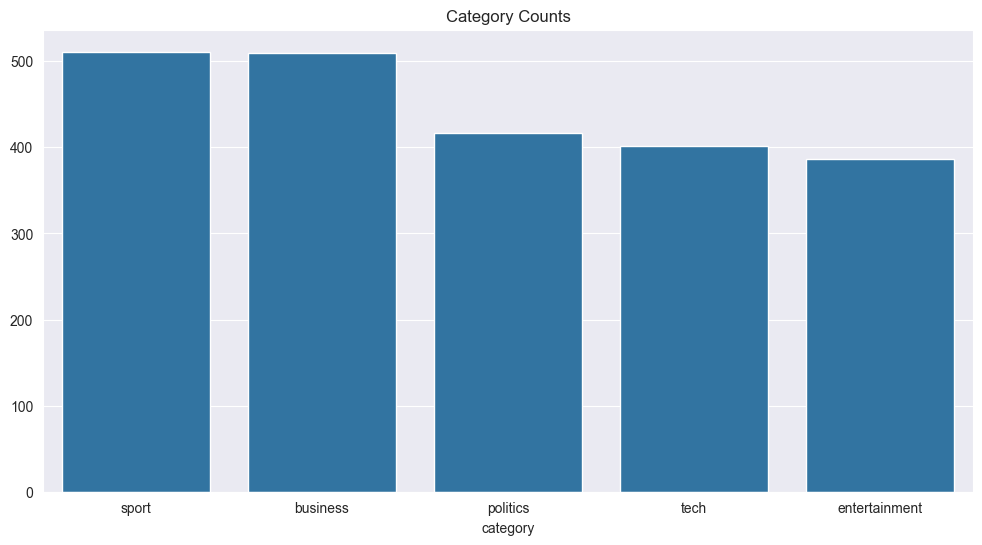

In [4]:
# Distro of category column in our dataset
category_counts = dataset.category.value_counts()
print("Category counts:\n", category_counts)

# Plotting the distribution of category column
plt.figure(figsize=(12,6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title("Category Counts")
plt.show()

In [5]:
# Distribution of text word count
dataset['word_count'] = dataset.text.apply(lambda x: len(x.split(' ')))
print("Average word count:", dataset.word_count.mean())
print("Max word count:", dataset.word_count.max())
print("Min word count:", dataset.word_count.min())

Average word count: 419.75730337078653
Max word count: 4759
Min word count: 94


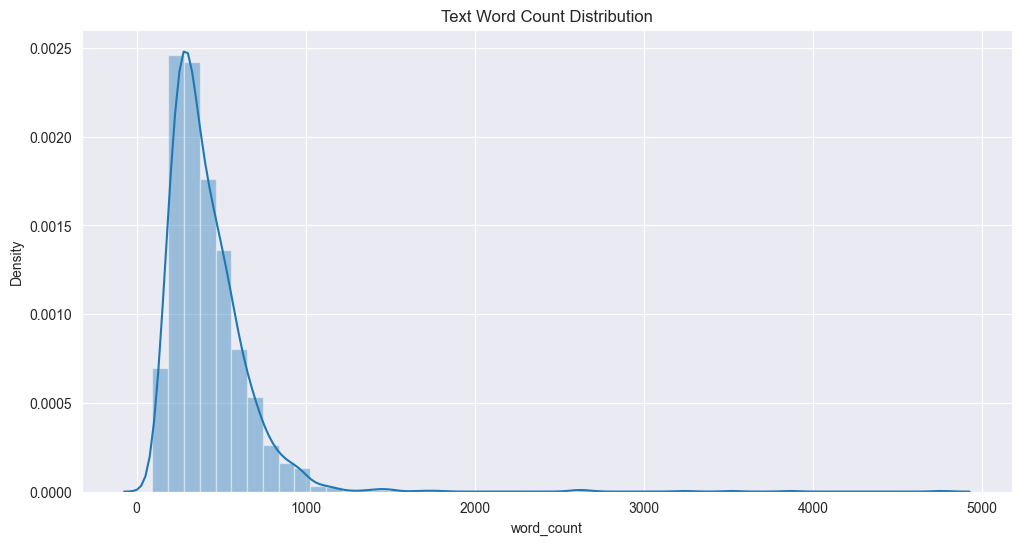

In [6]:
# Plotting the distribution of text word count
plt.figure(figsize=(12,6))
sns.distplot(dataset.word_count)
plt.title("Text Word Count Distribution")
plt.show()

In [7]:
# Coding target column to numeric
dataset['target'] = dataset.category.astype('category').cat.codes
# Original values and their corresponding codes
print("Original values and their corresponding codes:")
for cat, code in zip(dataset.category.unique(), dataset.target.unique()):
    print("     ", cat, ": ", code)

Original values and their corresponding codes:
      tech :  4
      business :  0
      sport :  3
      entertainment :  1
      politics :  2


In [8]:
mapper = dict(zip(dataset.target.unique(), dataset.category.unique()))

In [9]:
dataset.head(10)

,category,text,word_count,target
0,tech,tv future in the hands of viewers with home th...,806,4
1,business,worldcom boss left books alone former worldc...,332,0
2,sport,tigers wary of farrell gamble leicester say ...,270,3
3,sport,yeading face newcastle in fa cup premiership s...,390,3
4,entertainment,ocean s twelve raids box office ocean s twelve...,287,1
5,politics,howard hits back at mongrel jibe michael howar...,701,2
6,politics,blair prepares to name poll date tony blair is...,284,2
7,sport,henman hopes ended in dubai third seed tim hen...,202,3
8,sport,wilkinson fit to face edinburgh england captai...,163,3
9,entertainment,last star wars not for children the sixth an...,253,1


In [10]:
X = dataset.text.to_list()
y = dataset.target.to_list()

In [11]:
# Splitting the dataset into train, test and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.01, random_state=42)

## Model definition

Model link: https://huggingface.co/distilbert-base-uncased

In [12]:
# Loading the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [13]:
# Encoding the training and validation set
train_encodings = tokenizer(X_train, truncation=True, padding=True) #TruncationStrategy is the opposite of padding
val_encodings = tokenizer(X_val, truncation=True, padding=True)

In [14]:
# Creating torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

In [15]:
train_dataset = Dataset(train_encodings, y_train)
val_dataset = Dataset(val_encodings, y_val)

## Fine-tuning the model

In [16]:
from torch.nn.parallel import DistributedDataParallel
from transformers import Trainer, TrainingArguments

# Training pipeline
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=8,             # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    eval_steps=100
)

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

# Initialize PyTorch DistributedDataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    model = DistributedDataParallel(model)
        
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=888, training_loss=0.22761848523818493, metrics={'train_runtime': 14933.1381, 'train_samples_per_second': 0.944, 'train_steps_per_second': 0.059, 'total_flos': 1867360351272960.0, 'train_loss': 0.22761848523818493, 'epoch': 8.0})

In [18]:
trainer.evaluate()

{'eval_loss': 0.09472580999135971,
 'eval_runtime': 162.0501,
 'eval_samples_per_second': 2.746,
 'eval_steps_per_second': 0.043,
 'epoch': 8.0}

In [52]:
# Show accuracy on test set
test_encodings = tokenizer(X_test, truncation=True, padding=True)
test_dataset = Dataset(test_encodings, y_test)
trainer.evaluate(test_dataset)

{'eval_loss': 0.0007290563080459833,
 'eval_runtime': 6.487,
 'eval_samples_per_second': 2.775,
 'eval_steps_per_second': 0.154,
 'epoch': 8.0}

In [53]:
from sklearn.metrics import accuracy_score

predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=1)
true_labels = y_test

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")


Accuracy on the test set: 100.00%


is it overfitting?

## Save and Load the model

In [19]:
# Saving the model
model_path = 'models/distilbert-base-uncased'
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('models/distilbert-base-uncased\\tokenizer_config.json',
 'models/distilbert-base-uncased\\special_tokens_map.json',
 'models/distilbert-base-uncased\\vocab.txt',
 'models/distilbert-base-uncased\\added_tokens.json')

In [20]:
# Loading the model
model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizer.from_pretrained(model_path)

In [35]:
sample_text = X_test[1]
print(sample_text)

south africa sweep top awards south africa s schalk burger was named player of the year as the tri-nations champions swept the top honours at the international rugby board s awards.  the flanker topped a list which included ireland star gordon d arcy and australian sensation matt giteau. jake white claimed the coaching award while his side held off grand slam winners france to take the team award. england player simon amor beat team-mate ben gollings and argentine lucio lopez fleming to win the sevens award. burger s award came just a week after he won the equivalent prize from his fellow international players and white  who also coached burger at under-21 level  paid tribute to him.  schalk s emergence as a major force has meant a lot to south african rugby  but has also influenced world rugby   said white.  he s become to south african rugby what jonty rhodes was to south african cricket. it s amazing what he has achieved in such a short time so far in his international career.  amor

In [36]:
encoded_input = tokenizer(sample_text, truncation=True, padding=True, return_tensors='pt' # pt for pytorch and tf for tensorflow
)
output = model(**encoded_input)
output

SequenceClassifierOutput(loss=None, logits=tensor([[-2.0519, -2.2036, -2.1504,  6.8715, -2.2921]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [44]:
torch.argmax(output[0].detach()).item()

3

In [45]:
def predict(text) -> int:
    encoded_input = tokenizer(text, truncation=True, padding=True, return_tensors='pt' # pt for pytorch and tf for tensorflow
    )
    output = model(**encoded_input)
    return torch.argmax(output[0].detach()).item()

## Full pytorch pipeline

In [46]:
model_path = 'models/distilbert-base-uncased'

# Loading the model
model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizer.from_pretrained(model_path)

def predict(text) -> int:
    encoded_input = tokenizer(text, truncation=True, padding=True, return_tensors='pt' # pt for pytorch and tf for tensorflow
    )
    output = model(**encoded_input)
    return torch.argmax(output[0].detach()).item()

In [68]:
mapper[predict(X_test[3])]

'sport'

In [69]:
mapper[predict("corruption in fifa")]

'sport'

## Optimizing the model (Training without using Trainer class from transformers)

In [25]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 4 # I have weak gpu

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [50]:
# Creating the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, eps=1e-8)

In [51]:
# Creating the learning rate scheduler
from transformers import get_linear_schedule_with_warmup

epochs = 4 # Total number of training epochs, values more than 4 may lead to overfitting
total_steps = len(train_dataset) * epochs # Total number of training steps

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0, # Number of warmup steps
                                            num_training_steps=total_steps)

In [52]:
# Structure of the model
list(model.children())

[DistilBertModel(
   (embeddings): Embeddings(
     (word_embeddings): Embedding(30522, 768, padding_idx=0)
     (position_embeddings): Embedding(512, 768)
     (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     (dropout): Dropout(p=0.1, inplace=False)
   )
   (transformer): Transformer(
     (layer): ModuleList(
       (0-5): 6 x TransformerBlock(
         (attention): MultiHeadSelfAttention(
           (dropout): Dropout(p=0.1, inplace=False)
           (q_lin): Linear(in_features=768, out_features=768, bias=True)
           (k_lin): Linear(in_features=768, out_features=768, bias=True)
           (v_lin): Linear(in_features=768, out_features=768, bias=True)
           (out_lin): Linear(in_features=768, out_features=768, bias=True)
         )
         (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
         (ffn): FFN(
           (dropout): Dropout(p=0.1, inplace=False)
           (lin1): Linear(in_features=768, out_features=3072, bias=True)

In [53]:
def flat_accuracy(logits, label_ids):
    # Function to calculate the accuracy of our predictions vs labels
    # logits: the model predictions
    # label_ids: the actual labels
    # Returns the accuracy of our predictions vs labels as a float
    
    # Take the maximum value from the logits as our predicted label
    pred_flat = np.argmax(logits, axis=1).flatten()
    
    # Take the labels from the label_ids and flatten them
    labels_flat = label_ids.flatten()
    
    # Calculate the number of correctly classified examples
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [56]:
from babel.dates import format_time
import time

model.cuda() # Moving the model to GPU for faster training
loss_values = [] # Store the training loss values for plotting the learning curve
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []


for i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(i + 1, epochs))
    print('Training...')
    
    time_0 = time.time()
    
    total_loss = 0 # Reset the total loss for this epoch
    
    model.train() # Set the model to training mode
    
    for step, batch in enumerate(train_dataloader):
        
        # Updating progress every 40 batches
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes (How much time has passed since we started training)
            elapsed = time.time() - time_0
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        # Unpack this training batch from our dataloader.
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch['input_ids'].to('cuda')
        b_input_mask = batch['attention_mask'].to('cuda')
        b_labels = batch['labels'].to('cuda')
        
        # Clear any previously calculated gradients before performing a backward pass
        model.zero_grad()
        
        # Perform a forward pass (evaluate the model on this training batch)
        outputs = model(b_input_ids, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        loss = outputs[0]
        
        total_loss += loss.item() # .item() method to extract a scalar value from a tensor containing a single value
        
        # Perform a backward pass to calculate the gradients
        # It references back to all the computations that were performed in the forward pass and stored in computational graph and applies the chain rule to compute the gradients
        loss.backward()
        
        # Clip the norm of the gradients to 1.0 to prevent "exploding gradients" (a common problem in NLP)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step() # Update parameters and take a step using the computed gradient
        
        scheduler.step() # Update the learning rate
        
    avg_train_loss = total_loss / len(train_dataloader) # Calculate the average loss over all of the batches
    
    loss_values.append(avg_train_loss) # Store the loss value for plotting the learning curve
    
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    training_time = time.time() - time_0
    print("  Training epoch took: {:}".format(training_time))
    
    print("")
    print("Running Validation...")
    
    time_0 = time.time()
    model.eval() # Put the model in evaluation mode
    
    total_val_accuracy = 0
    total_val_loss = 0
    nb_val_steps = 0
    
    for batch in validation_dataloader:
            
            b_input_ids = batch['input_ids'].to('cuda')
            b_input_mask = batch['attention_mask'].to('cuda')
            b_labels = batch['labels'].to('cuda')
            
            # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training)
            with torch.no_grad(): # Save computing and memory resources 
                outputs = model(b_input_ids, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)
            
            loss = outputs[0]
            logits = outputs[1]
            
            total_val_loss += loss.item()
            
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            
            total_val_accuracy += flat_accuracy(logits, label_ids)
    
    avg_val_accuracy = total_val_accuracy / len(validation_dataloader)
    
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    
    avg_val_loss = total_val_loss / len(validation_dataloader)
    
    validation_time = time.time() - time_0
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    441.    Elapsed: 16.654215097427368.
  Batch    80  of    441.    Elapsed: 32.97686719894409.
  Batch   120  of    441.    Elapsed: 49.349823236465454.
  Batch   160  of    441.    Elapsed: 65.72876405715942.
  Batch   200  of    441.    Elapsed: 82.08373761177063.
  Batch   240  of    441.    Elapsed: 98.45009088516235.
  Batch   280  of    441.    Elapsed: 115.12406635284424.
  Batch   320  of    441.    Elapsed: 131.47401309013367.
  Batch   360  of    441.    Elapsed: 147.7953896522522.
  Batch   400  of    441.    Elapsed: 164.10895609855652.
  Batch   440  of    441.    Elapsed: 180.4179584980011.

  Average training loss: 0.24
  Training epoch took: 180.72695589065552

Running Validation...
  Accuracy: 0.98
  Validation Loss: 0.10
  Validation took: 18.819260835647583

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    441.    Elapsed: 16.10506772994995.
  Batch    80  of    441.    Elapsed: 32.414127588

In [55]:
torch.cuda.empty_cache()

In [61]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.239178,0.096131,0.979911,180.726956,18.819261
2,0.096785,0.091791,0.982143,179.743130,18.878859
3,0.057451,0.100922,0.984375,179.823812,18.834104
4,0.023027,0.180548,0.975446,180.052009,18.894544


In [62]:
# Saving the model
model_path = 'models/distilbert-base-uncased_' + str(time.time())
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('models/distilbert-base-uncased_1706611142.2826495\\tokenizer_config.json',
 'models/distilbert-base-uncased_1706611142.2826495\\special_tokens_map.json',
 'models/distilbert-base-uncased_1706611142.2826495\\vocab.txt',
 'models/distilbert-base-uncased_1706611142.2826495\\added_tokens.json')

In [65]:
# Applying the model on test set
# Show accuracy on test set
test_encodings = tokenizer(X_test, truncation=True, padding=True)
test_dataset = Dataset(test_encodings, y_test)

test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [69]:
model.eval()
total_accuracy = 0
total_steps = 0
total_loss = 0

for batch in test_dataloader:
    b_input_ids = batch['input_ids'].to('cuda')
    b_input_mask = batch['attention_mask'].to('cuda')
    b_labels = batch['labels'].to('cuda')
    
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    
    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    total_accuracy += flat_accuracy(logits, label_ids)
    total_loss += outputs[0].item()
    total_steps += 1

avg_accuracy = total_accuracy / total_steps
avg_loss = total_loss / total_steps

print("Accuracy: {0:.2f}".format(avg_accuracy * 100))
print("Loss: {0:.2f}".format(avg_loss))

Accuracy: 100.00
Loss: 0.00


Maybe overfitting? or just good results?